# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

from ppo import PPOMemory, ActorNetwork, CriticNetwork, PPOAgent
import train_ppo as tppo

# Check devices
print(f"mps available: {torch.backends.mps.is_available()}")
print(f"mps built: {torch.backends.mps.is_built()}")
print(f"cuda available: {torch.cuda.is_available()}")

mps available: False
mps built: False
cuda available: False


## MVP Environment

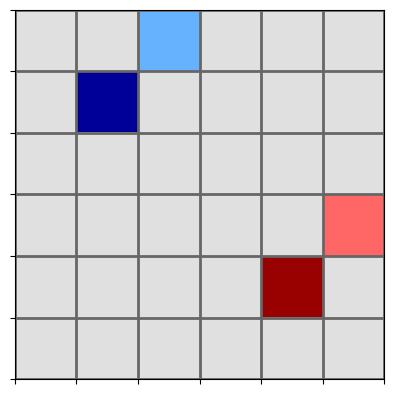

In [2]:
# instantiate environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=6,
                   N_AGENTS=2)
env.render()

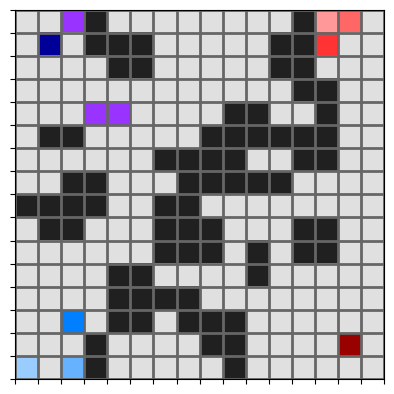

In [3]:
# instantiate environment
env = GridworldCtf(GAME_MODE='random',
                   GRID_LEN=16,
                   N_AGENTS=6,
                   ENABLE_PICKUPS=True,
                   ENABLE_OBSTACLES=True,
                   MAX_BLOCK_TILE_PCT=0.33,
                   MAX_HEALTH_PICKUP_TILES=3
                   )
env.render()

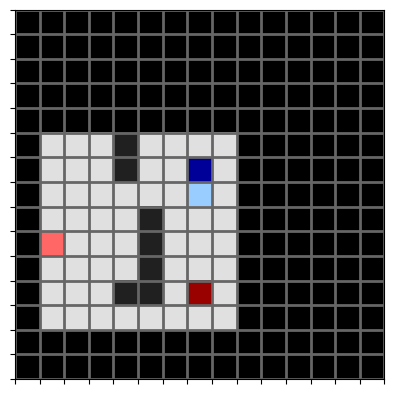

You win!, total score 263


In [5]:
# playing against random agents
env = GridworldCtf(GAME_MODE='random',
                   GRID_LEN=8,
                   N_AGENTS=2,
                   ENABLE_OBSTACLES=True,
                   AGENT_CONFIG = {
                        0: {'team':0, 'type':2},
                        1: {'team':1, 'type':0},
                        2: {'team':0, 'type':1},
                        3: {'team':1, 'type':1},
                        4: {'team':0, 'type':2},
                        5: {'team':1, 'type':2}
                    }
                   )
env.play(player=0, render_ego_state=True)


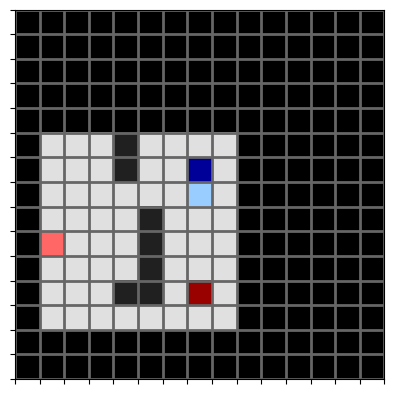

In [6]:
env.render(ego_state_agent=0)

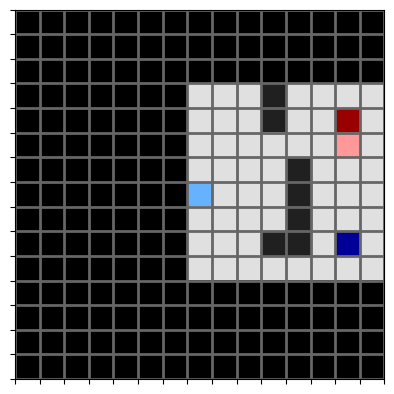

In [7]:
env.render(ego_state_agent=1)

## Deep Q-Network

### Train agents - Flag carriers only

In [19]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=7,
                   N_AGENTS=4)
device = "cpu"

# configure agents
n_actions = 8
n_channels = 1
batch_size = 32
gamma = 0.9
lr = 0.00005
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
use_softmax = True
loss = 'mse'

agent_t1 = DQNAgent(name='dqn_t1',
                    grid_len=env.GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

agent_t2 = DQNAgent(name='dqn_t2',
                    grid_len=env.GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                epochs=1000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                use_ego_state=False,
                                scale_tiles=False,
                                device=device)

episode: 996                 
total step count: 282910                 
episode step count: 253                 
score: -512                 
average score: -366.2                 
epsilon: 0.3695                 
done count: 996                 
team 1 captures: 1940                 
team 2 captures: 2323


In [17]:
# Save models
agent_t1.save_model()
agent_t2.save_model()

#### Performance metrics

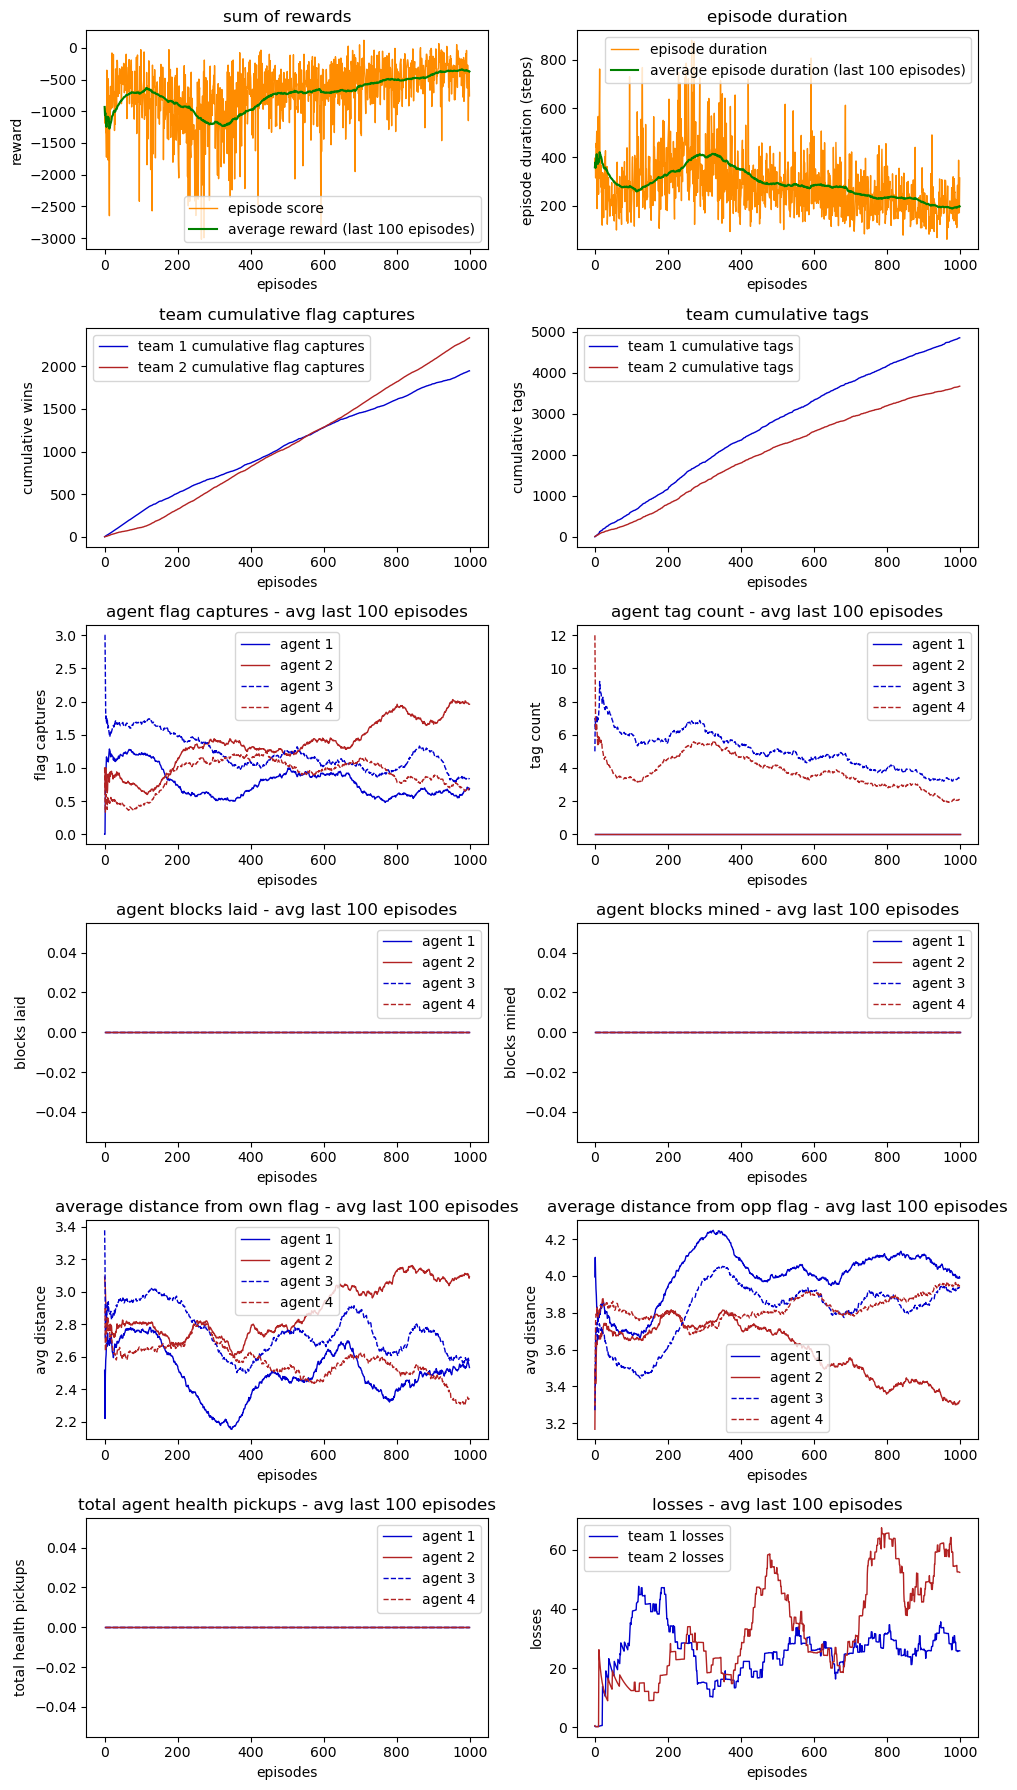

In [20]:
ut.plot_training_performance(training_metrics)

#### Inference

In [8]:
# create agents
use_softmax = True
agent_t1 = DQNAgent(name='dqn_t1',
                      use_softmax=use_softmax)

agent_t2 = DQNAgent(name='dqn_t2',
                      use_softmax=use_softmax)


In [17]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=6,
                   N_AGENTS=2)
                   

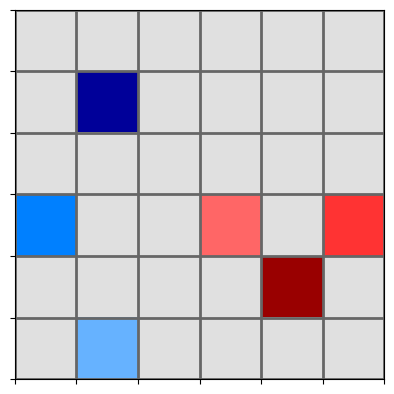

Game won!                       
Final score: 152                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 37


In [12]:
# test model
# env_dims = (1, 1, 6, 6)
ut.test_model(env, 
             agent_t1, 
             agent_t2, 
             display=True, 
             max_moves=100,
             use_ego_state=False,
             scale_tiles=False)

### Train with standardised state

In [14]:
# create environment
env = GridworldCtf(GAME_MODE='static',
                   GRID_LEN=6,
                   N_AGENTS=4)
device = "cpu"

# configure agents
n_actions = 8
n_channels = 1
batch_size = 32
gamma = 0.9
lr = 0.00005
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
use_softmax = True
loss = 'mse'

agent_t1 = DQNAgent(name='dqn_t1',
                    grid_len=env.EGO_GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

agent_t2 = DQNAgent(name='dqn_t2',
                    grid_len=env.EGO_GRID_LEN,
                    n_actions=n_actions,
                    n_channels=n_channels,
                    batch_size=batch_size,
                    gamma=gamma,
                    lr=lr,
                    epsilon=epsilon,
                    target_update_steps=target_update_steps,
                    mem_size=mem_size,
                    use_softmax=use_softmax,
                    loss=loss,
                    device=device)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                epochs=1000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                use_ego_state=True,
                                scale_tiles=False,
                                device=device)

episode: 996                 
total step count: 141191                 
episode step count: 19                 
score: 224                 
average score: 192.88                 
epsilon: 0.3695                 
done count: 994                 
team 1 captures: 823                 
team 2 captures: 2712


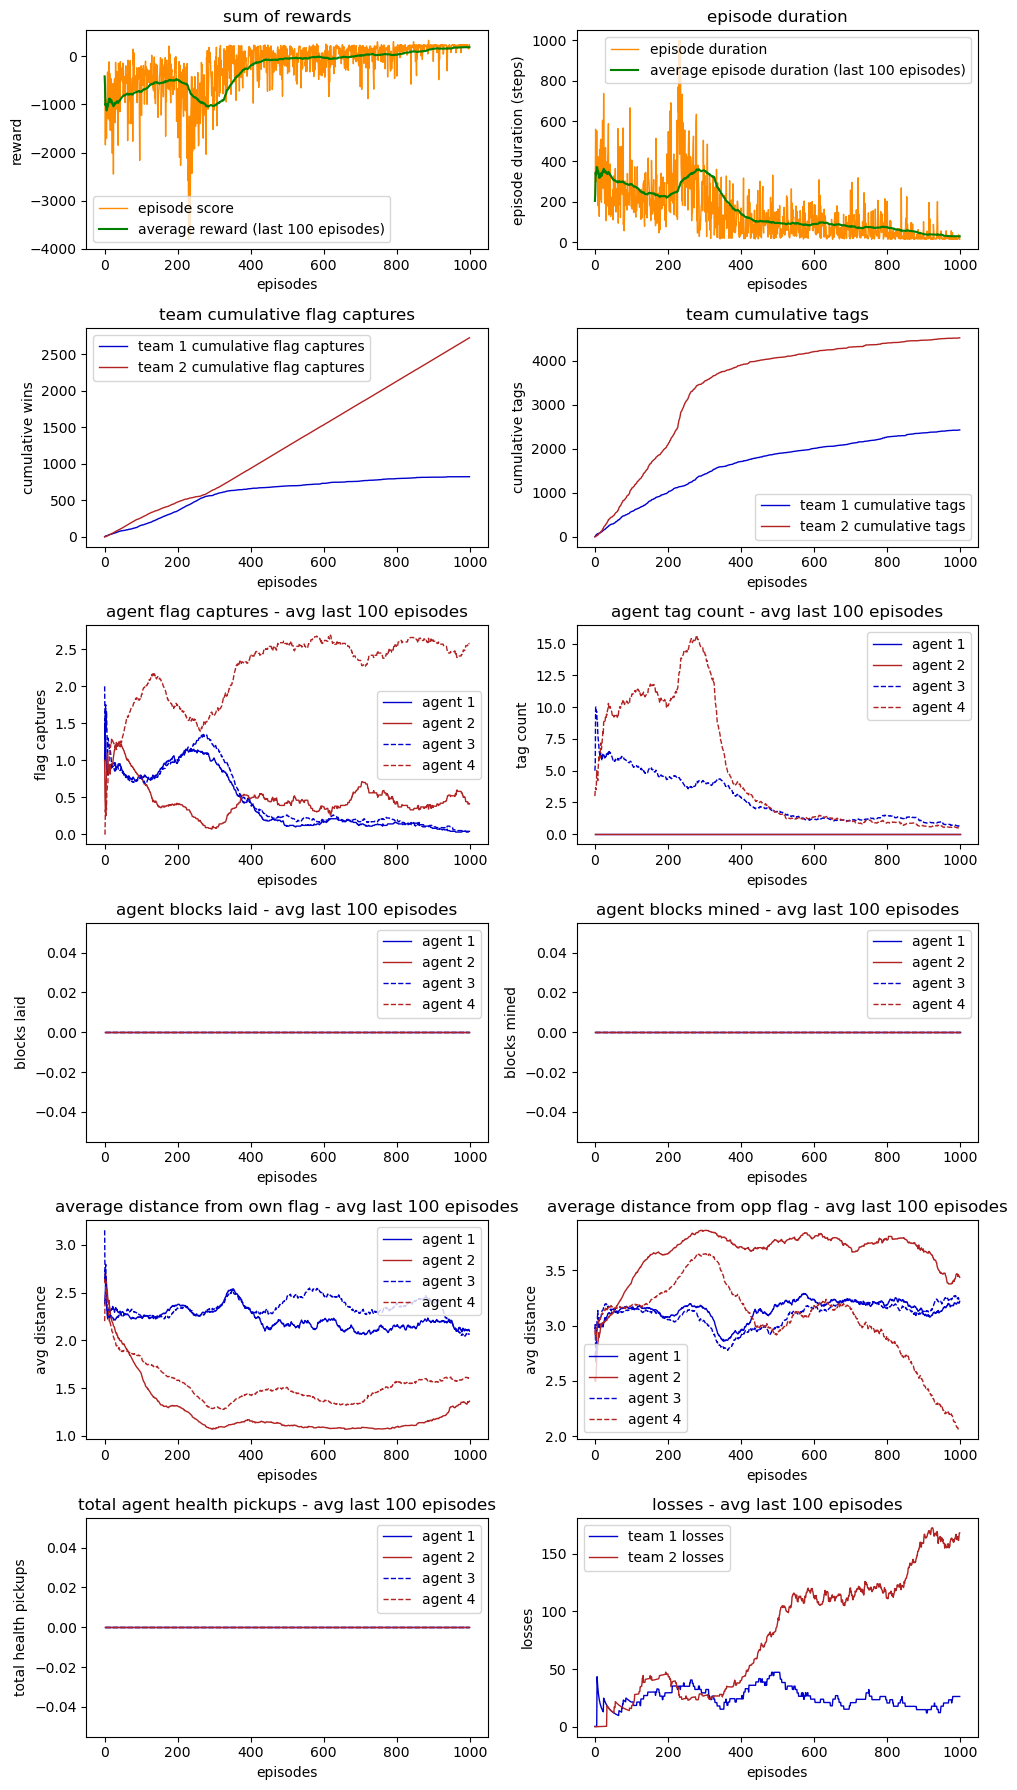

In [15]:
ut.plot_training_performance(training_metrics)

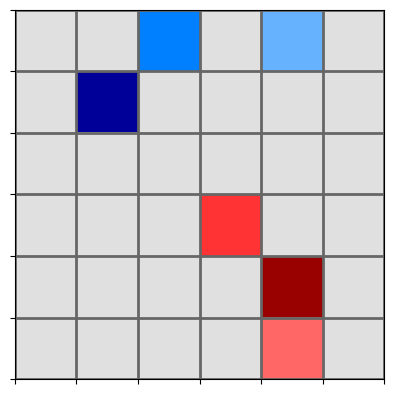

Game won!                       
Final score: 224                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 19


In [18]:
ut.test_model(env, 
             agent_t1, 
             agent_t2, 
             display=True, 
             max_moves=100,
             use_ego_state=True,
             scale_tiles=False)

#### Interactive play with trained agents

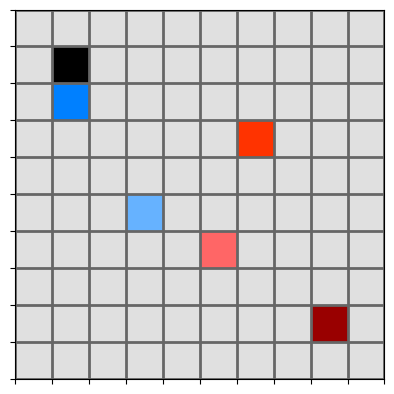

You win!, total score 141


In [12]:
env = GridworldCtf(game_mode='static')
env.play(player=0, agents=agents)

## Proximal Policy Optimisation

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
from dueling_dqn_network import DuelingDQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

from ppo import PPOMemory, ActorNetwork, CriticNetwork, PPOAgent
import train_ppo as tppo

In [16]:
env = GridworldCtf(GAME_MODE='static',
                    GRID_LEN=6,
                    N_AGENTS=2)
n_actions = 8
n_episodes = 500
learning_steps=20
max_steps=1000
batch_size = 32
n_epochs = 4
alpha = 0.0003
policy_clip = 0.2
softmax_temp = 1.3


agent_t1 = PPOAgent(n_actions=n_actions, 
                    batch_size=batch_size, 
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs,
                    grid_len=env.GRID_LEN,
                    softmax_temp=softmax_temp)

agent_t2 = PPOAgent(n_actions=n_actions, 
                    batch_size=batch_size, 
                    alpha=alpha, 
                    policy_clip=policy_clip,
                    n_epochs=n_epochs, 
                    grid_len=env.GRID_LEN,
                    softmax_temp=softmax_temp)    

training_metrics = tppo.train_ppo(env,
                        agent_t1,
                        agent_t2,
                        n_episodes,
                        learning_steps=learning_steps,
                        max_steps=max_steps,
                        use_ego_state=False,
                        scale_tiles=False,
                        device='cpu')
    

episode: 1                 
total step count: 356                 
episode step count: 356                 
score: -312                 
average score: -312.0                 
done count: 1                 
team 1 captures: 1                 
team 2 captures: 3                 
actions: [3, 0]


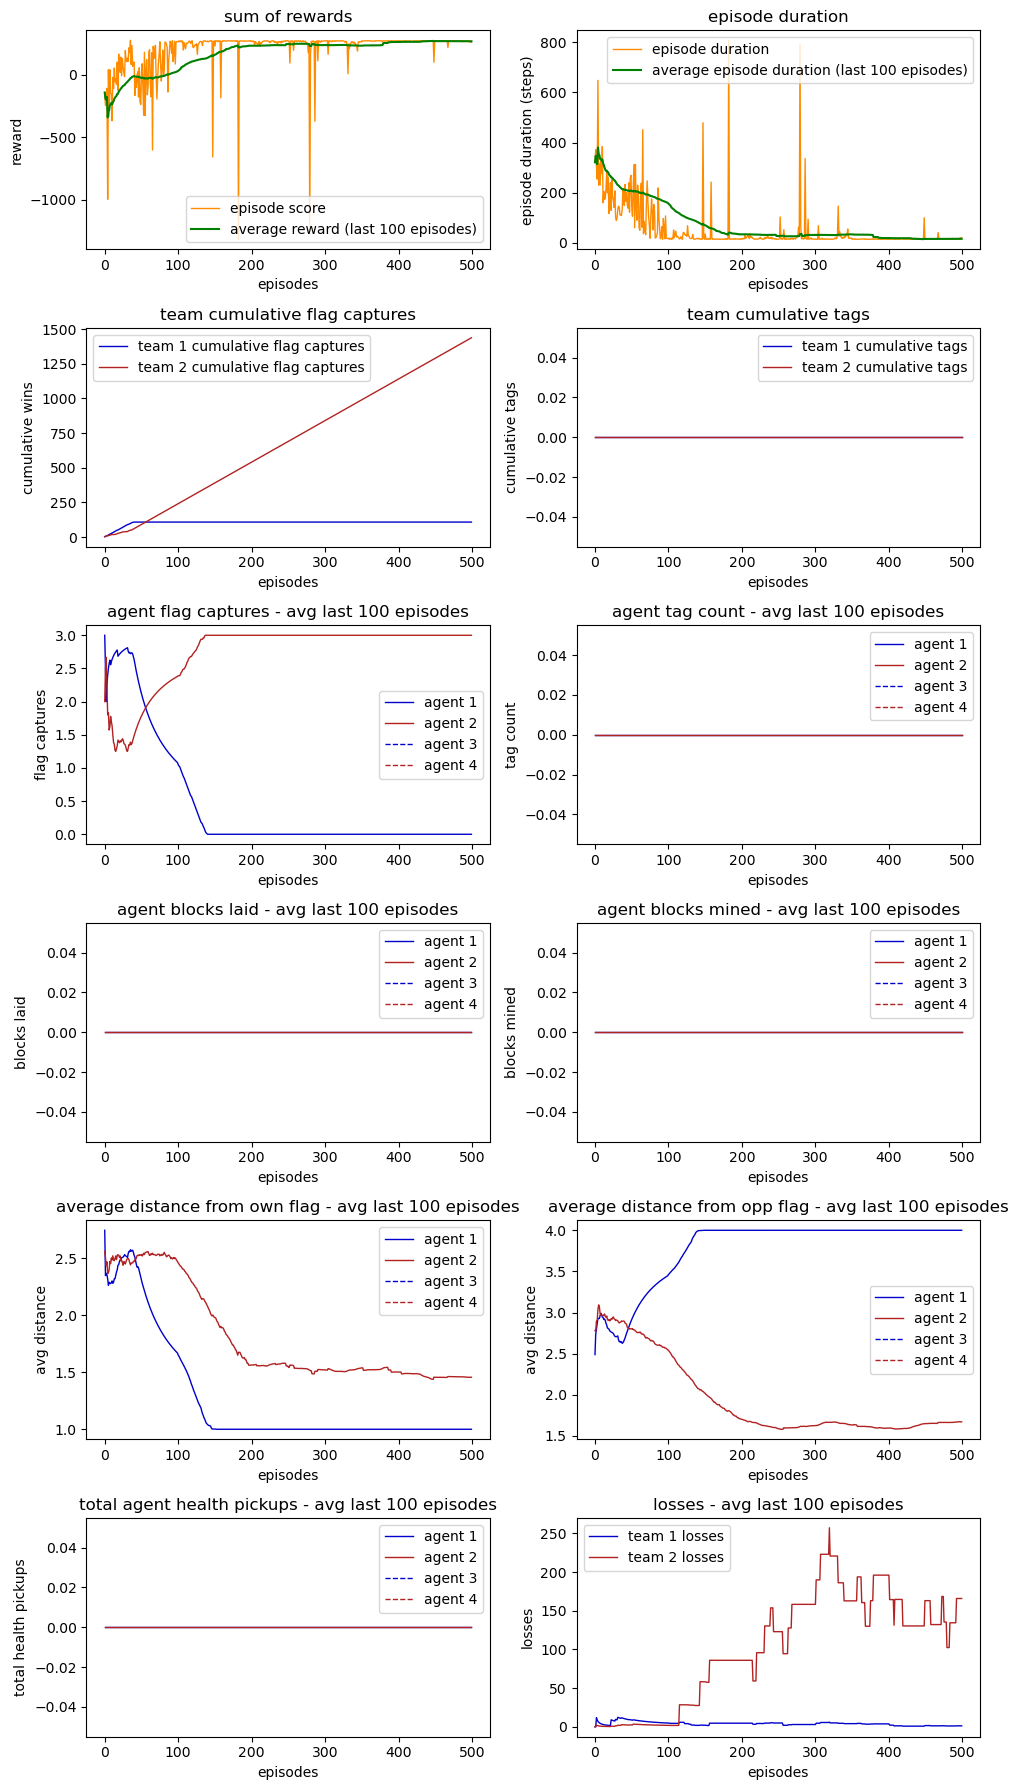

In [13]:
ut.plot_training_performance(training_metrics)

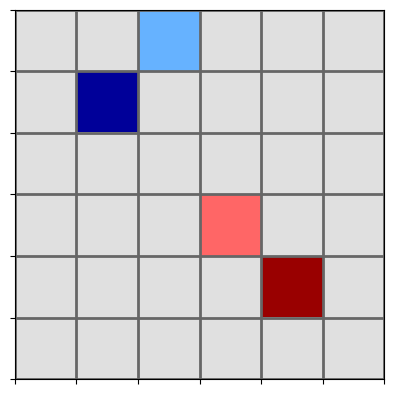

Game won!                       
Final score: 272                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 14


In [14]:
ut.test_model_ppo(env, 
                agent_t1, 
                agent_t2, 
                display=True, 
                use_ego_state=False,
                scale_tiles=False,
                max_moves=100, 
                device='cpu')